In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.regression import GeneralizedLinearRegression
import pyspark.sql.functions as func
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import RegressionMetrics

data = spark.read.format('csv').options(header='true', inferSchema='true').load('/FileStore/tables/officer_before.csv')
data = spark.table("settlements")

col = [
 'rank1',
 'race1',
 'gender1',
 'num_allegations',
 'settlement_age',
 'num_settlements',
 'settlement_amount',
 'district_id',
 'sum_Attendance Recognition Award',
 'sum_Complimentary Letter',
 'sum_Department Commendation',
 'sum_Deployment Operations Center Award',
 'sum_Honorable Mention',
 'sum_Joint Operations Award',
 'sum_Life Saving Award',
 'sum_Military Deployment Award',
 'sum_Military Service Award',
 'sum_Outside Governmental Agency Award',
 'sum_Police Blue Shield Award',
 'sum_Police Officer Of The Month Award',
 'sum_Problem Solving Award',
 'sum_Special Commendation',
 "sum_Superintendent'S Honorable Mention",
 'sum_Superintendents Award Of Merit',
 'sum_Superintendents Award Of Valor',
 'sum_Traffic Stop Of The Month Award',
 'sum_Unit Meritorious Performance Award']

df = data[col]
col.remove('settlement_amount')

assembler = VectorAssembler(inputCols=col, outputCol="features")
df = assembler.transform(df)

train, test = df.randomSplit([0.9, 0.1], seed=12345)

glr = GeneralizedLinearRegression(family="gaussian", link="log", labelCol='settlement_amount', featuresCol='features')

paramGrid = ParamGridBuilder().addGrid(glr.regParam, np.linspace(0.01,0.5,5)).addGrid(glr.maxIter,[10,50]).build()

crossval = CrossValidator(estimator=glr,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol='settlement_amount'),
                          numFolds=3) 

cvModel = crossval.fit(train)

actual  = test.select('settlement_amount')
#test.drop('settlement_amount')
prediction = cvModel.transform(test)

glrevaluator = RegressionEvaluator(labelCol='settlement_amount',predictionCol='prediction',metricName='r2')

print(glrevaluator.evaluate(prediction))

model = cvModel.bestModel
print("Coefficients: " + str(model.coefficients))


0.1638684887342735
Coefficients: [0.150514747526,0.0391893028843,0.0589275878749,-0.00315276083466,-0.0262453748918,-0.0662531114266,0.0148556837765,-0.112702642533,-0.0479489781499,-0.0244758198547,-0.0153420662084,-0.127200639381,-0.0168167932416,-0.0211317523282,-0.00230847941144,-0.00578552020855,-0.0251747714481,0.00119660840587,-0.000717849568196,-0.00653466404731,0.104204433023,-0.00637582762032,-0.00874135812865,0.0357458977753,-0.0152430017315,0.0825128905804]

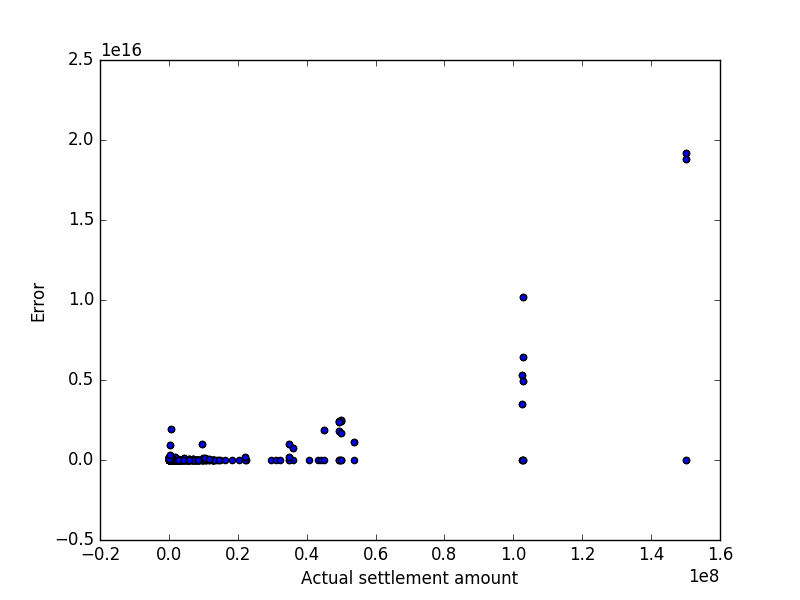

In [2]:
pred = prediction.select('prediction').collect()
act = prediction.select('settlement_amount').collect()
err = (np.array(pred)-np.array(act))**2

plt.scatter(act,err)
plt.xlabel('Actual settlement amount')
plt.ylabel('Error')
display(plt.show())


In [3]:
display(pred)

prediction
6466811.632661868
5240225.231838539
3490394.146355718
2764955.1968706786
865386.2860620515
2632764.5521177384
8186177.601331063
828108.9503589255
2669298.8822830236
2.9568175763822082E7


In [4]:
display(act)

settlement_amount
550000
990000
420000
487500
300000
950000
10000
350000
200000
102500000


In [5]:
act = test.filter(test.settlement_amount.between(0,10000000))
act = act.select('settlement_amount').collect()
display(act)

settlement_amount
550000
990000
420000
487500
300000
950000
10000
350000
200000
600000
